# MLBA homework4

### Some utilities

In [62]:
using LinearAlgebra
using VMLS
using Plots
import Random
using DataFrames

### Question_1

a. Find the coefficients of LS solutions.

b. What is the predicted house price at area = 1.01, beds = 4, and location = 4.

c.  Plot price_i in the y-axis and price in the x-axis and a 45-degree line.

x從上到下依序是beta_0, beta_1, ..., beta6

(1)平均而言，area每上升一單位，房價就會上升195個單位。然而area^2的係數是負的，代表area的影響會隨著area越來越大而平緩。

（2）平均而言嗎，beds每下降一單位，房價就會上升16個單位。

（3）Hold others fixed, 平均而言，location_1的房屋價格 > loc_4 > loc_2 > loc_3。

In [63]:
# a.
D = house_sales_data();  
area = D["area"];
area_square = area.^2;
beds = D["beds"];
loc = D["location"];
loc_1 = zeros(length(loc))
loc_2 = zeros(length(loc))
loc_3 = zeros(length(loc))
for i in 1:length(loc)
    if loc[i] == 1
        loc_1[i] = 1
    end
    if loc[i] == 2
        loc_2[i] = 1
    end
    if loc[i] == 3
        loc_3[i] = 1
    end
end
price = D["price"];

A = [ones(length(price)) area area_square beds loc_1 loc_2 loc_3];  
x = A \ price             

7-element Vector{Float64}:
  76.32921595922653
 195.53184347837168
 -12.755474952829335
 -16.059942082519548
  27.798103881489904
 -75.0798251263162
 -82.21351116253774

In [64]:
# b.
[1, 1.01, 1.01^2, 4, 0, 0, 0]'*x

196.56474954292253

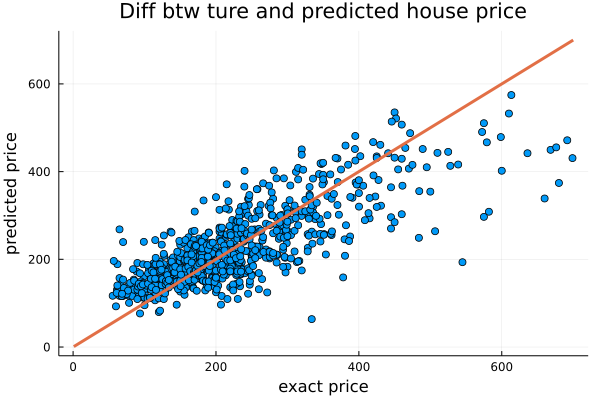

In [65]:
# c.
p_hat = [ones(length(price)) area area_square beds loc_1 loc_2 loc_3]*x
scatter(price, p_hat, legend=false, markersize = 4, xlabel= "exact price", ylabel = "predicted price", title = "Diff btw ture and predicted house price")
plot!(1:700, 1:700,linewidth = 3)

### Question 2

5- fold cross validation

a. The coefficients of 5 models?

b.  training errors and testing errors?

In [66]:
N = length(price)
nfold = div(N,5)
I = Random.randperm(N);

models = zeros(7,5); 
errors = zeros(5, 2); 
for k = 1:5
    if k == 1
        Itrain = I[nfold+1:end]; # seperate the training set and 
        Itest = I[1:nfold];
    elseif k == 5
        Itrain = I[1:4*nfold];
        Itest = I[4*nfold+1:end];
    else
        Itrain = I[ [1:(k-1)*nfold ; k*nfold+1 : N]]
        Itest = I[ [(k-1)*nfold+1 ; k*nfold ]];
    end;
    Ntrain = length(Itrain)
    Ntest = length(Itest)
    theta = A[Itrain,:] \ price[Itrain];
    errors[k, 1] = rms(A[Itrain,:] * theta - price[Itrain]);  # training set
    errors[k, 2] = rms(A[Itest,:] * theta - price[Itest]);    # testing set
    models[:,k] = theta;
end;
df = DataFrame(model_1 = models[:,1], model_2 = models[:,2], model_3 = models[:,3], model_4 = models[:,4], model_5 = models[:,5])

,model_1,model_2,model_3,model_4,model_5
,Float64,Float64,Float64,Float64,Float64
1,73.1891,65.3506,75.2447,79.6061,89.4538
2,201.543,189.498,184.809,213.989,188.173
3,-13.6145,-11.9683,-11.1792,-17.1855,-9.71687
4,-18.6834,-11.9633,-12.4027,-20.5966,-17.3614
5,17.6186,28.9769,29.5191,35.1178,26.6878
6,-69.7047,-69.163,-72.9132,-80.076,-83.6625
7,-75.0201,-79.4885,-79.5905,-88.8933,-87.8803


In [67]:
DataFrame(training_rms = errors[:, 1], testing_rms = errors[:,2])

,training_rms,testing_rms
,Float64,Float64
1,68.15,70.0861
2,68.623,27.8838
3,67.9498,33.6856
4,65.5214,49.2518
5,71.3445,56.5607


### Question 3

a. Build a multiclass (linear) classifier with intercept for the iris dataset using all four 
features. What are the coefficients?

b. Construct the 3 × 3 confusion matrix for this example.

a小題：coefficient 是一個5*3的matrix。 

（說明）對任一個1x5的entry（intercept feature_1 ... feature_4）而言，經由一個線性轉換，他的output會是一個1x3的matrix，分別是該entry在每個類別的‘分數（機率）’。

因此，input是1x5， output是1x3，該線性轉換的size才會是5x3，也就是coefficients。

In [68]:
# a.
D = iris_data();
setosa = D["setosa"];
versicolor = D["versicolor"];
virginica = D["virginica"];
iris = [setosa; versicolor; virginica]'
features = [ones(1, 150); iris]
truth = [ ones(50); 2*ones(50); 3*ones(50) ];
function ls_multiclass(X,ycl,K)
    n, N = size(X) # 5 features, 150 entreis.
    Theta = X' \ (2*one_hot(ycl,K) .- 1) # to 1 and -1 (one-hot vector)
    yhat = row_argmax(X'*Theta)          # 3 linear system
return Theta, yhat
end
Theta, yhat = ls_multiclass(features, truth, 3);
Theta

5×3 Matrix{Float64}:
 -0.763554   2.15412    -2.39056
  0.13206   -0.0403074  -0.0917522
  0.485696  -0.891233    0.405537
 -0.449314   0.441338    0.00797582
 -0.114945  -0.988613    1.10356

In [69]:
confusion_matrix(truth, yhat, 3)

3×3 Matrix{Float64}:
 50.0   0.0   0.0
  0.0  34.0  16.0
  0.0   7.0  43.0

### Question 4
a. Build an auto-regressive time series model with the memory of 1, 5, and 10.

這個模型的係數和rms 如下所示，係數由上到下依序是Z(t-1), Z(t-5), Z(t-10)的

b. Plot the temperature and the predictions from the three memory of 1, 5, and 10 in 
one diagram. What do you observe?

（1）分別建立三個模型

（2）將他們的預測值和真實值畫圖，比較模型的預測效果、係數大小以及rms

結果：發現分別用延後一期、五期或十期的資料來預測現在的天氣，3個模型的預測效果從圖上來看，沒有顯著的差異。然而，rms是AR(1) > AR(5) > AR(10), 所以預測效果還是AR(1)比較好！

In [70]:
t = temperature_data();
N = length(t)
M = 10
y = t[M+1:end];
A = hcat( [ t[i:i+N-M-1] for i = [M, M-4, M-9]]...);
theta = A \ y; # 模型係數
ypred = A * theta; # 預測值
theta 

3-element Vector{Float64}:
  1.1284931145456059
 -0.2173651397360723
  0.08872296958554589

In [71]:
rms(ypred - y) # RMS error of LS AR fit

1.0301257926783958

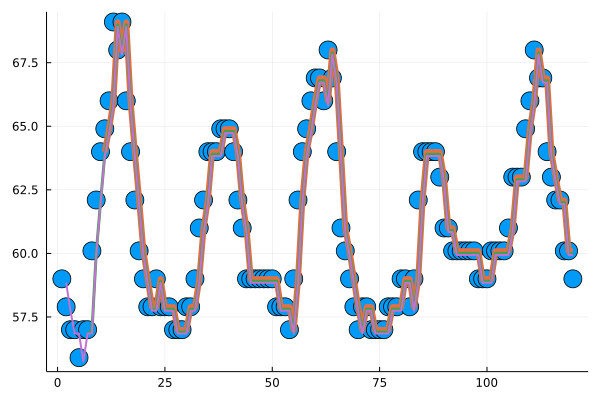

In [72]:
predicted_t = zeros(734, 3)
i = 1
for M in [10, 6, 1]
    y = t[10+1:end];
    A = t[M:M+N-11];
    theta = A \ y; # 模型係數
    ypred = A * theta; # 預測值
    predicted_t[:, i] = ypred
    i += 1
end
Nplot = 24*5
scatter(1:Nplot, t[1:Nplot], legend =false, markersize = 10)
plot!(10+1:Nplot, predicted_t[:,1][1:Nplot-10], linewidth = 6)
plot!(6+1:Nplot, predicted_t[:,2][1:Nplot-6], linewidth = 3)
plot!(1+1:Nplot, predicted_t[:,3][1:Nplot-1], linewidth = 2)

In [73]:
rms_t = zeros(1, 3)
i = 1
for M in [10, 6, 1]
    y = t[10+1:end];
    A = t[M:M+N-11];
    theta = A \ y; # 模型係數
    ypred = A * theta; # 預測
    rms_t[1, i] = rms(ypred - y)
    i += 1
end
rms_t

1×3 Matrix{Float64}:
 1.15456  3.80598  5.31104

In [2]:
A = [1 0; 0 1; -2 3]
A*inv(A'*A)*A'

3×3 Matrix{Float64}:
  0.714286  0.428571  -0.142857
  0.428571  0.357143   0.214286
 -0.142857  0.214286   0.928571